# KMeans: choosing clusters

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
penguins = sns.load_dataset('penguins').dropna()
penguins.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
142,Adelie,Dream,32.1,15.5,188.0,3050.0,Female
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
280,Gentoo,Biscoe,45.3,13.8,208.0,4200.0,Female
68,Adelie,Torgersen,35.9,16.6,190.0,3050.0,Female
207,Chinstrap,Dream,52.2,18.8,197.0,3450.0,Male


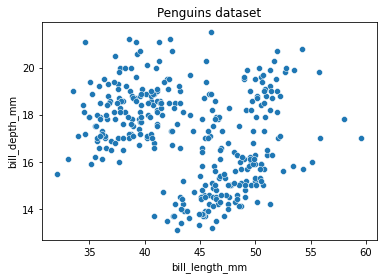

In [ ]:
penguins.dropna(inplace=True)
plt.title('Penguins dataset')
sns.scatterplot(data=penguins, x='bill_length_mm',	y='bill_depth_mm')
plt.show()

In [ ]:
columns = ['bill_length_mm', 'bill_depth_mm']

peng_sample = penguins.filter(columns)
peng_sample.head(3)

,bill_length_mm,bill_depth_mm
0,39.1,18.7
1,39.5,17.4
2,40.3,18.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
peng_norm = MinMaxScaler().fit_transform(peng_sample)
pd.DataFrame(peng_norm, columns=columns).head()

,bill_length_mm,bill_depth_mm
0,0.254545,0.666667
1,0.269091,0.511905
2,0.298182,0.583333
3,0.167273,0.738095
4,0.261818,0.892857


In [ ]:
from sklearn.cluster import KMeans
peng_kmeans = KMeans(n_clusters=3).fit(peng_norm)

peng_kmeans

KMeans(n_clusters=3)

## Ways to find the right number of clustes

### Visualise the relation between variables

In [ ]:
columns = ['bill_length_mm', 'bill_depth_mm']

centroids = pd.DataFrame(peng_kmeans.cluster_centers_)
centroids.columns = columns
centroids

,bill_length_mm,bill_depth_mm
0,0.549303,0.224802
1,0.243784,0.613578
2,0.646378,0.667033


In [ ]:
plot_data = pd.DataFrame(peng_norm)
plot_data.columns = columns
plot_data['cluster'] = peng_kmeans.labels_#peng_kmeans.predict(peng_norm)
plot_data.head()

,bill_length_mm,bill_depth_mm,cluster
0,0.254545,0.666667,1
1,0.269091,0.511905,1
2,0.298182,0.583333,1
3,0.167273,0.738095,1
4,0.261818,0.892857,1


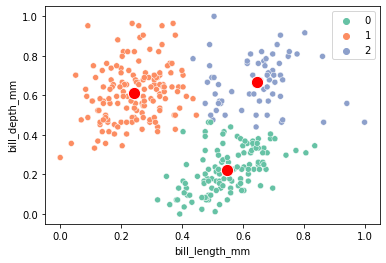

In [ ]:
sns.scatterplot(data=plot_data, x='bill_length_mm', y='bill_depth_mm', hue='cluster', palette='Set2')
sns.scatterplot(data=centroids, x='bill_length_mm', y='bill_depth_mm', color='red', s=150)
plt.show()

### Evaluate when checking the distance between centroids

In [ ]:
centroids

,bill_length_mm,bill_depth_mm
0,0.549303,0.224802
1,0.243784,0.613578
2,0.646378,0.667033


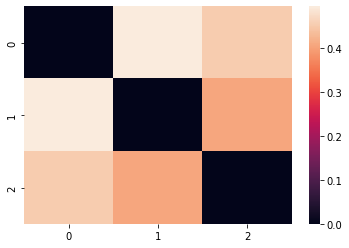

In [ ]:
def manhattan_distance(data, student, student_to_compare): 
    distance = (
        pd.DataFrame({
            'student_1':data.loc[student,:],
            'student_2':data.loc[student_to_compare,:]
        })
        # applying the formula
        .assign(dist_abs = lambda x: abs(x.student_1 - x.student_2))
        .agg({'dist_abs':'sum'})[0]
    )
    return distance

def euclidean_distance(data, student, student_to_compare): 
    distance = (
        pd.DataFrame({
            'student_1':data.loc[student,:],
            'student_2':data.loc[student_to_compare,:]
        })
        # applying the formula
        .assign(dist_abs = lambda x: (x.student_1 - x.student_2)**2)
        .agg({'dist_abs':'sum'})[0]**0.5
    )
    return distance


def get_distances(data, distance_type='euclidean'):
    """
    Given a dataframe, return the distance between all the indexes. 
    We assume the indexes represents the users/students. 
    Args: 
        * dataset 
        * distance type to perform the operation (euclidean or manhattan)
    """
    if distance_type == 'manhattan': 
        distances = [[manhattan_distance(data, student, student_to_compare) for student in data.index] for student_to_compare in data.index]
    else: 
        distances = [[euclidean_distance(data, student, student_to_compare) for student in data.index] for student_to_compare in data.index]
        
    return pd.DataFrame(distances, columns=data.index, index=data.index)


sns.heatmap(get_distances(centroids))
plt.show()

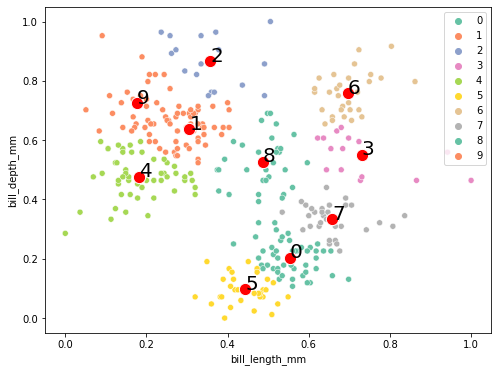

In [ ]:
temp_kmeans = KMeans(n_clusters=10).fit(peng_norm)

centroids_temp = pd.DataFrame(temp_kmeans.cluster_centers_)
centroids_temp.columns = columns
centroids_temp['cluster_name'] = centroids_temp.index

plot_data['cluster'] = temp_kmeans.labels_

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=plot_data, x='bill_length_mm', y='bill_depth_mm', hue='cluster', palette='Set2')
sns.scatterplot(data=centroids_temp, x='bill_length_mm', y='bill_depth_mm', color='red', s=150)
for i in range(centroids_temp.shape[0]):
    plt.text(
        x=centroids_temp['bill_length_mm'][i], 
        y=centroids_temp['bill_depth_mm'][i],
        s=centroids_temp['cluster_name'][i], 
        size=20
    )
plt.show()

dist_temp = get_distances(centroids_temp.drop('cluster_name', axis=1))

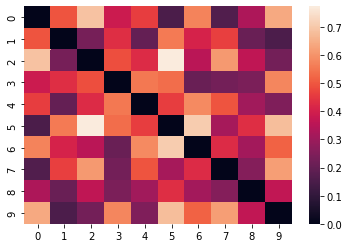

In [ ]:
sns.heatmap(dist_temp)

### Using inertia

In [ ]:
peng_kmeans.inertia_

31.37542741206378
15.50163534882866
8.769486294749548
6.750833591705225
5.110493661666955
4.310101589528514
3.721945415784777
3.2981730763822914
2.917793186967068
2.597082783411466
2.437181782347905
2.203412716215555
1.9788908283370308
1.846493464940564


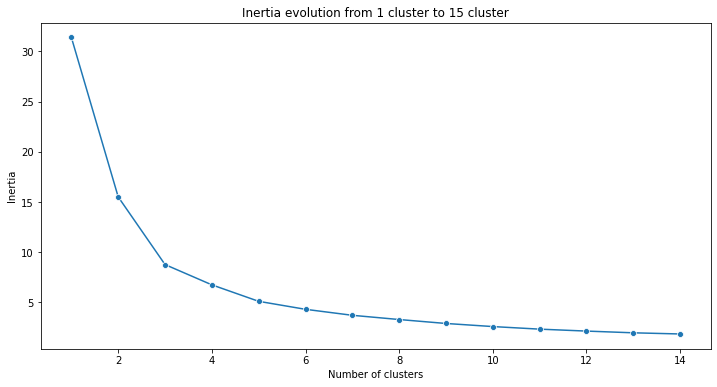

In [ ]:
max_k = 15
inertia = []

for k in range(1, max_k): 
    print(KMeans(n_clusters=k).fit(peng_norm).inertia_)
    inertia.append(KMeans(n_clusters=k).fit(peng_norm).inertia_)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Inertia evolution from 1 cluster to {max_k} cluster')
sns.lineplot(x=range(1, max_k), y=inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

### Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(peng_norm, peng_kmeans.labels_)

0.5139272799995429

In [ ]:
mykmean = KMeans(n_clusters=2).fit(peng_norm)

In [ ]:
#mykmean.

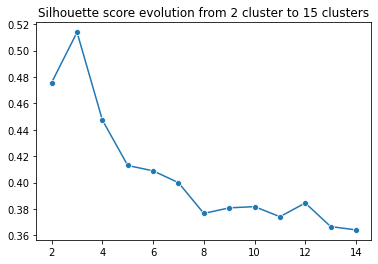

In [ ]:
max_k = 15
sil_score = []

for k in range(2, max_k): 
    labels = KMeans(n_clusters=k).fit(peng_norm).labels_
    #print(labels)
    sil_score.append(silhouette_score(peng_norm, labels))

plt.title(f'Silhouette score evolution from 2 cluster to {max_k} clusters')
sns.lineplot(x=range(2, max_k), y=sil_score, marker='o')
plt.show()

The silhouette coefficient can vary between -1 and +1: 

|   |   |
|---|---|
|+1   | Closter to +1 the instance is well inside its own cluster and far from other clusters.  |
|0   | Closter to 0 the instance is close to a cluster boundary.   |
|-1   | Closer to -1 the instance may have been assigned to the wrong cluster.  |